<a href="https://colab.research.google.com/github/mrpc25/TaikoLevelModel/blob/main/UseModel_all_attentionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Packages
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.copyfile('drive/MyDrive/taiko.py', 'taiko.py')

from taiko import TaikoFumen
from taiko import TaikoFumenInner
from taiko import TaikoFumenBranched

import numpy as np
import torch
import torchaudio
from torch import nn

import gc
import math

from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def TimeDisplay(seconds):
    D_str = ""
    H_str = ""
    M_str = ""
    MS_str = ""
    D = int(seconds // 86400)
    seconds = seconds - D*86400
    H = int(seconds // 3600)
    seconds = seconds - H*3600
    M = int(seconds // 60)
    seconds = seconds - M*60
    S = int(seconds // 1)
    sconds = seconds - S
    MS = round((seconds%1)*1000)
    if D!=0: D_str = f"{D}d "
    if D!=0 or H!=0: H_str = f"{H}h "
    if D!=0 or H!=0 or M!=0: M_str = f"{M}m "
    if D!=0 or H!=0 or M!=0 or S!=0: MS_str = f"{S}s "
    return f"{D_str}{H_str}{M_str}{MS_str}{MS}ms"

Mounted at /content/drive


In [2]:
# @title Fumen / Audio Basic Setting

PRECHOOSE_COURSE = 'Oni' # @param ["Easy", "Normal", "Hard", "Oni", "Edit"] {allow-input: false}
PRECHOOSE_BRANCH = 2 # @param ["0", "1", "2"] {type:"raw"}

match PRECHOOSE_BRANCH:
    case 0: PRE_BRANCH_STR = "普通譜面"
    case 1: PRE_BRANCH_STR = "玄人譜面"
    case 2: PRE_BRANCH_STR = "達人譜面"
    case _: raise Exception("Please Enter A Integer In One Of Them: [0, 1, 2]")


In [39]:
# @title Fumen Info Loading
Codec = "big5" # @param ["utf_8", "ascii", "shift_jis", "big5", "hz", "unicode_escape", "raw_unicode_escape"] {allow-input: true}
fumen_path = "/content/drive/MyDrive/FumenToPredict/touhou.tja" # @param {type:"string"}
offset_shift = 0 # @param {type:"number"}

def ReadingFile(used_codec):
    #第一階段分析譜面 -> 分析所有有出現的譜面版本 (難度分類/是否雙人，但不分次郎定義的表裏譜面)
    song_basic = TaikoFumen(fumen_path, used_codec)
    #依照檔案當中所有出現的譜面版本做選擇
    for state in song_basic.FumanClassfication:
        if(state[1]==PRECHOOSE_COURSE):
            diff_sign = state[0]
            break
    #第二階段分析譜面 -> 分析第一階段所選譜面內容，並分析出三種可能分岐(或沒有)
    song_selected = TaikoFumenInner(fumen_path, used_codec, diff_sign)
    #依照上階段所選譜面的分岐條件做選擇，也可能沒有分歧
    Branch_sign = PRECHOOSE_BRANCH if song_selected.IsBranchExist else None
    #最後決定的譜面
    return TaikoFumenBranched(fumen_path, used_codec, diff_sign, Branch_sign)

Codec_To_Try = [Codec, "utf_8", "big5", "shift_jis", "raw_unicode_escape"]
Reading_Success = False
for Choesn_Codec in Codec_To_Try:
    try:
        song_branched = ReadingFile(Choesn_Codec)
        Reading_Success = True
        break
    except:
        pass

if not Reading_Success:
    raise Exception("Unable Reading File After Using All Codecs\n")

audio_name = song_branched.OffsetThingsValue_PareIgnored("WAVE:",[0, len(song_branched.EveryRow)])

def FilePathOnlyDir(path):
    if "/" not in path: return ""
    while(path[-1]!="/" and len(path)>0): path = path.rstrip(path[-1])
    return path
Audio_path = FilePathOnlyDir(fumen_path) + audio_name

LocationToNotes = song_branched.FindEveryPassedNotesLocation()
OFFSETString = song_branched.OffsetThingsValue("OFFSET:", [0, song_branched.Song_Begin[0]])
OFFSET = 0 if OFFSETString=='' else float(OFFSETString)
AbsoluteTime = [-OFFSET + song_branched.Duration([0,0],location)[0] for location in LocationToNotes]
MeasureConfiguration = song_branched.Find_BeatsToMeasure_Of_EachNotesInLoaction()
BpmConfiguration = song_branched.Find_BPM_Of_EachNotesInLoaction()

print(f"PreChoose State\t:{PRECHOOSE_COURSE}/{PRE_BRANCH_STR}")
print(f"Audio Path \t:{Audio_path}")
print(f"Offset Value\t:{-OFFSET}s")

if(offset_shift!=0):
  print(f"Offset Shift\t:{-offset_shift}s")
  print(f"Offset Final\t:{-OFFSET-offset_shift}s")
  OFFSET = OFFSET - offset_shift


PreChoose State	:Oni/達人譜面
Audio Path 	:/content/drive/MyDrive/FumenToPredict/Touhou_Suite.ogg
Offset Value	:2.226088s


##Multiple To Multiple

In [ ]:
# @title Model/Parameter Defining { form-width: "240px" }
import torch.nn.functional as F

MODEL_PATH = "/content/drive/MyDrive/20240721/seq_24_inarow/2_9364_6076.pth" # @param ["/content/drive/MyDrive/20240721/seq_32_inarow_37_63/1_10973_5335.pth", "/content/drive/MyDrive/20240721/embed_size_24_rollu_op_drop_ignored0.3/17_9051_6140.pth", "/content/drive/MyDrive/20240721/embed_size_24_rollu_op/1_9244_6171.pth", "/content/drive/MyDrive/20240721/embed_size_24_rollu_op_drop/1_9064_6186.pth", "/content/drive/MyDrive/20240721/seq_24_inarow/2_9364_6076.pth", "/content/drive/MyDrive/20240721/seq_24_inarow_all/6_8863_6359.pth", "/content/drive/MyDrive/20240721/seq_24_inarow_all_tl/43_8813_6316.pth"] {allow-input: true}

SEQ = 24 # @param {type:"integer"}
DUAL_CHANNEL = False # @param {type:"boolean"}
BATCH_FIRST = False # @param {type:"boolean"}
EXTRA_NOTEPAIR = 1
CHANNRL = 2 if DUAL_CHANNEL else 1
C = (0*2 + 1) * CHANNRL

C = CHANNRL


softmax = nn.Softmax(dim=1)

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(q, k, v)
        return attn_output

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class TaikoNoteClassfication(nn.Module):
    def __init__(self, out_dim, C=C, num_patches=SEQ, emb_dim=128, n_layers=6, dropout=0.1, heads=4):
        super(TaikoNoteClassfication, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=C, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.fc = nn.Linear(12288, emb_dim)

        self.channels = C
        self.n_layers = n_layers

        num_patches = num_patches
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential\
            (
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout)))
            )
            self.layers.append(transformer_block)

        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))

        A = torch.ones(num_patches, emb_dim)
        for pos in range(num_patches):
          for i in range(emb_dim):
            x = i//2
            A[pos][i] = torch.sin(torch.tensor(pos/1000**(x/emb_dim))) if (i % 2 == 0) else torch.cos(torch.tensor(pos/1000**(x/emb_dim)))
        self.basic_pos_emb_unit = A.to(device)

    def forward(self, x):

        batch_size, sequence_length, channels, height, width = x.size()
        x = x.view(batch_size * sequence_length, channels, height, width)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(batch_size, sequence_length, -1)
        x = self.fc(x)
        b, n, _ = x.shape

        position_encoding = self.basic_pos_emb_unit.repeat(b, 1, 1)
        x = x + position_encoding

        cls_tokens = self.cls_token.repeat(b, 1, 1)
        x = torch.cat([cls_tokens, x], dim=1)

        for i in range(self.n_layers): x = self.layers[i](x)
        return self.head(x[:, 1:, :])

device = "cuda" if torch.cuda.is_available() else "cpu"

model = TaikoNoteClassfication(5).to(device)

MAGNIFY = 1
# PERIOD = 1
FREQ_BINS = 64
SEGMENT = 100
# SR = 44100
# SHAPE = int(PERIOD*SEGMENT+1)

#載入儲存好的模型
TaikoModel = TaikoNoteClassfication(5).to(device)
TaikoModel.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
TaikoModel.state_dict()
TaikoModel.eval()

device


'cpu'

In [ ]:
# @title Fumen Predicting { form-width: "450px" }
import time

inference_time = 0

print(f"Model patch\t\t:{MODEL_PATH}")
print(f"Audio Path\t\t:{Audio_path}")
print(f"Sequence length\t\t:{SEQ}")

NeedNormalized = False # @param {type:"boolean"}
Possibilty_Computation = 'Raw -> Sum/Avg -> Softmax' # @param ["Raw -> Sum/Avg -> Softmax", "Raw -> Softmax -> Sum/Avg", "Raw -> Softmax -> Multiply -> RootBack"] {allow-input: false}

predictBar = torch.zeros(SEQ, CHANNRL, 64, 101).to(device)
match Possibilty_Computation:
  case "Raw -> Sum/Avg -> Softmax"|"Raw -> Softmax -> Sum/Avg":
    predictResult = torch.zeros(len(LocationToNotes), 5).to(device)
  case "Raw -> Softmax -> Multiply -> RootBack":
    predictResult = torch.ones(len(LocationToNotes), 5).to(device)
# predictResult = torch.zeros(len(LocationToNotes), 5).to(device)
abs_pos = torch.tensor(range(1-SEQ, 1)).to(device)

def AdjustPeriod(period):
    while(period>=4): period = period/2
    while(period<=1/4): period = period*2
    return period

SOUNDWAVE, SR = torchaudio.load(Audio_path)
SOUNDWAVE = SOUNDWAVE * MAGNIFY
SOUNDWAVE = SOUNDWAVE.to(device)
FRAMES_LENGTH = len(SOUNDWAVE[0])

channel_num = (SOUNDWAVE.shape)[0]
assert channel_num==1 or channel_num==2, "Number of channel is not valid, expect 1 or 2."
if(channel_num==1 and DUAL_CHANNEL):      SOUNDWAVE = SOUNDWAVE.repeat(2, 1)                               #將單聲道轉為雙聲道
if(channel_num==2 and not DUAL_CHANNEL):  SOUNDWAVE = torch.unsqueeze((SOUNDWAVE[0]+SOUNDWAVE[1])/2, 0)    #將雙聲道轉為單聲道

BEFORE_overall = time.time()
for NOTE_INDEX, location in enumerate(tqdm(LocationToNotes)):
    [BAR, NOTE] = location
    BPM = BpmConfiguration[BAR][NOTE]
    PERIOD = AdjustPeriod(60 / BPM * 2)
    SHAPE = int(PERIOD*SEGMENT+1)

    EXACT_TIME = AbsoluteTime[NOTE_INDEX]-PERIOD/2
    STARTING_FRAME = int(EXACT_TIME*SR)
    DURATION_FRAME = int(PERIOD*SR)

    ZERO_CHANNEL_TENSOR = torch.full((CHANNRL, 1), 0).to(device)

    #起始點是否在音樂開始前 / 起始點是否在音樂開始後 / 終止點是否在音樂開始前 / 終止點是否在音樂結束後
    IS_START_OUT_OF_MIN_INDEX = False if (STARTING_FRAME>=0) else True
    IS_START_OUT_OF_MAX_INDEX = False if (STARTING_FRAME<FRAMES_LENGTH) else True
    IS_FINAL_OUT_OF_NIN_INDEX = False if (STARTING_FRAME+DURATION_FRAME>=0) else True
    IS_FINAL_OUT_OF_NAX_INDEX = False if (STARTING_FRAME+DURATION_FRAME<FRAMES_LENGTH) else True

    assert not(IS_START_OUT_OF_MIN_INDEX and IS_START_OUT_OF_MAX_INDEX), f"The Start Window being Out Of Start/End point At The Same Time Doesn't Make Sense."
    assert not(IS_FINAL_OUT_OF_NIN_INDEX and IS_FINAL_OUT_OF_NAX_INDEX), f"The Final Window being Out Of Start/End point At The Same Time Doesn't Make Sense."

    match IS_START_OUT_OF_MIN_INDEX, IS_START_OUT_OF_MAX_INDEX, IS_FINAL_OUT_OF_NIN_INDEX, IS_FINAL_OUT_OF_NAX_INDEX:
        case False  , False , _     , False : #正常情況
            SLICE = SOUNDWAVE[:, STARTING_FRAME: STARTING_FRAME+DURATION_FRAME]
        case True   , False , False , False : #開頭超出音樂開頭處，結尾則在音樂內
            SLICE = SOUNDWAVE[:, 0: STARTING_FRAME+DURATION_FRAME]
            while(len(SLICE[0])<DURATION_FRAME): SLICE = torch.cat((ZERO_CHANNEL_TENSOR, SLICE), dim=1)
        case True   , False , True , False : #開頭和結尾都超出音樂開頭處
            SLICE = torch.zeros(CHANNRL, DURATION_FRAME).to(device)
        case False  , False , _    , True  : #結尾超出音樂結束處，開頭則在音樂內
            SLICE = SOUNDWAVE[:, STARTING_FRAME: FRAMES_LENGTH]
            while(len(SLICE[0])<DURATION_FRAME): SLICE = torch.cat((SLICE, ZERO_CHANNEL_TENSOR), dim=1)
        case False  , True  , _    , True  : #開頭跟結尾都已經在整首音樂結束後了
            SLICE = torch.zeros(CHANNRL, DURATION_FRAME).to(device)
        case True   , _     , _    , True  : #不合理的情況，起始點在音樂開始前，終止點在音樂結束後
            raise Exception(f"Chosen Segment Is Less Then {PERIOD}s.")

    to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate = DURATION_FRAME,  n_fft = 1024,       n_mels = FREQ_BINS,
        hop_length = int( DURATION_FRAME / SEGMENT ),      f_min = 0,         f_max = int(SR/2),  normalized = True).to(device)

    log_mel_spec = to_mel_spectrogram(SLICE)

    for i in range(len(predictBar)-1):
        predictBar[i] = predictBar[i+1]
    predictBar[-1] = log_mel_spec

    with torch.inference_mode():
        #代進去時，要是batchxBEQx2x64x101
        predictBar_normalized = torch.nn.functional.normalize(predictBar.reshape(-1), dim=0).reshape(predictBar.shape) if (NeedNormalized) else predictBar
        BEFORE = time.time()
        Result = TaikoModel(torch.unsqueeze(predictBar_normalized, 0).to(device))
        inference_time += time.time() - BEFORE
        Result = torch.squeeze(Result)

    abs_pos = torch.tensor(range(NOTE_INDEX-SEQ+1, NOTE_INDEX+1))
    match Possibilty_Computation:
        case "Raw -> Sum/Avg -> Softmax":
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index>=0): predictResult[abs_index] += value
        case "Raw -> Softmax -> Sum/Avg":
          Result = softmax(Result)
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index>=0): predictResult[abs_index] += value
        case "Raw -> Softmax -> Multiply -> RootBack":
          Result = softmax(Result)
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index>=0): predictResult[abs_index] *= value
        case _:
          raise Exception("Please Enter A String In One Of Them: [Raw -> Sum/Avg -> Softmax, Raw -> Softmax -> Sum/Avg, Raw -> Softmax -> Multiply -> RootBack]")

    # abs_pos = torch.tensor(range(NOTE_INDEX-SEQ+1, NOTE_INDEX+1))
    # for abs_index, value in zip(abs_pos, Result):
    #     if(abs_index>=0): predictResult[abs_index] += value
overall = time.time() - BEFORE_overall

#倒數SEQ-1個音符需要補0來計算剩餘次數
for _ in range(SEQ-1):
    for i in range(len(predictBar)-1):
        predictBar[i] = predictBar[i+1]
    predictBar[-1] = torch.zeros(CHANNRL, FREQ_BINS, SEGMENT+1)

    with torch.inference_mode():
        #代進去時，要是batchxSEQx2x64x101
        predictBar_normalized = torch.nn.functional.normalize(predictBar.reshape(-1), dim=0).reshape(predictBar.shape) if (NeedNormalized) else predictBar
        Result = TaikoModel(torch.unsqueeze(predictBar_normalized, 0).to(device))
        Result = torch.squeeze(Result)

    abs_pos = abs_pos + 1
    match Possibilty_Computation:
        case "Raw -> Sum/Avg -> Softmax":
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index<len(LocationToNotes)): predictResult[abs_index] += value
        case "Raw -> Softmax -> Sum/Avg":
          Result = softmax(Result)
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index<len(LocationToNotes)): predictResult[abs_index] += value
        case "Raw -> Softmax -> Multiply -> RootBack":
          Result = softmax(Result)
          for abs_index, value in zip(abs_pos, Result):
              if(abs_index<len(LocationToNotes)): predictResult[abs_index] *= value
        case _:
          raise Exception("Please Enter A String In One Of Them: [Raw -> Sum/Avg -> Softmax, Raw -> Softmax -> Sum/Avg, Raw -> Softmax -> Multiply -> RootBack]")

    # abs_pos = abs_pos + 1
    # for abs_index, value in zip(abs_pos, Result):
    #     if(abs_index<len(LocationToNotes)): predictResult[abs_index] += value

match Possibilty_Computation:
  case "Raw -> Sum/Avg -> Softmax"|"Raw -> Softmax -> Sum/Avg":
    predictResult = predictResult / SEQ
  case "Raw -> Softmax -> Multiply -> RootBack":
    predictResult = predictResult ** (1/SEQ)
preductNote = predictResult.argmax(dim=1).tolist()

print(f"Inference Time\t\t:{TimeDisplay(inference_time)}s")
print(f"Inference Ratio\t\t:{round(inference_time/overall*10000)/100}%")

for x, y in zip(LocationToNotes, preductNote): song_branched.EveryBar[x[0]] = song_branched.EveryBar[x[0]][:x[1]] + str(y) + song_branched.EveryBar[x[0]][x[1]+1:]

Model patch		:/content/drive/MyDrive/20240721/seq_24_inarow/2_9364_6076.pth
Audio Path		:/content/drive/MyDrive/FumenToPredict/songforsmalllove.ogg
Sequence length		:24


  0%|          | 0/2847 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Inference Time		:7m 4s 84mss
Inference Ratio		:94.32%


In [ ]:
# @title Result { form-width: "240px" }

BarNumberDisplayed = True # @param {type:"boolean"}
Result_Display = "Save As File" # @param ["Print Out", "Save As File"]

#印出結果
TempContent = song_branched.OffsetThingsValue("BPM:",[song_branched.ChosenReady,song_branched.ChosenBegin]) #預設使用譜面開始前設定的BPM
if(TempContent==""): TempContent = song_branched.OffsetThingsValue("BPM:",[0, song_branched.Song_Begin[0]]) #沒有該譜面自設定的BPM，則沿用譜面檔案一開始能找到的數值

TITLE = song_branched.TITLE
SUBTITLE = song_branched.OffsetThingsValue("SUBTITLE:",[0,len(song_branched.EveryRow)])
INIT_BPM = TempContent
WAVE = song_branched.OffsetThingsValue("WAVE:",[0,len(song_branched.EveryRow)])
OFFSET = OFFSET
LEVEL = 8 # @param {type:"integer"}
COURSE = 3 # @param {type:"integer"}

_bpm = float(TempContent)
_scr = 1
_measure = [4, 4]
_barline = True
_gogo = False
_note = None

set_bpm = song_branched.BPMValueSet
set_scr = song_branched.ScrollSet
set_measure = song_branched.BeatsToMeasureSet
set_barline = song_branched.BarlineSet
set_gogo = song_branched.GOGOSet
set_delay = song_branched.DelaySet

Remastered_fumen = ""

#Basic Info
Remastered_fumen += f"TITLE:{TITLE}\n"
Remastered_fumen += f"SUBTITLE:{SUBTITLE}\n"
Remastered_fumen += f"BPM:{INIT_BPM}\n"
Remastered_fumen += f"WAVE:{WAVE}\n"
Remastered_fumen += f"OFFSET:{OFFSET}\n"
Remastered_fumen += f"LEVEL:{LEVEL}\n"
Remastered_fumen += f"COURSE:{COURSE}\n"

Remastered_fumen += "#START\n"

#Actual Fumen Context
for bar, bar_bpm, bar_scr, bar_measure, bar_barline, bar_gogo, bar_delay in zip(song_branched.EveryBar, set_bpm, set_scr, set_measure, set_barline, set_gogo, set_delay):
    for note, bpm, scr, measure, barline, gogo, delay in zip(bar, bar_bpm, bar_scr, bar_measure, bar_barline, bar_gogo, bar_delay):
        IsCommandChange = True if (_bpm, _scr, _measure, _barline, _gogo) != (bpm, scr, measure, barline, gogo) else False
        #如果現在有指令的話，會在開頭自動加上一次換行。而如果上一個位置就是小節結束點(換行)，那就省掉上一次加的換行
        if( IsCommandChange and ( _note == "," or _note is None ) ):  Remastered_fumen = Remastered_fumen[:-1]
        if(_bpm!=bpm):
            _bpm = bpm
            Remastered_fumen = Remastered_fumen + f"\n#BPMCHANGE {bpm}"
        if(_scr!=scr):
            _scr = scr
            Scroll_text = str(scr.real) if (scr.imag==0) else f"{scr.real}+{scr.imag}i"
            Remastered_fumen = Remastered_fumen + f"\n#SCROLL {Scroll_text}"
        if(_measure!=measure):
            _measure = measure
            Remastered_fumen = Remastered_fumen + f"\n#MEASURE {measure[0]}/{measure[1]}"
        if(_barline!=barline):
            _barline = barline
            Barline_text = "#BARLINEON" if barline else "#BARLINEOFF"
            Remastered_fumen = Remastered_fumen + f"\n{Barline_text}"
        if(_gogo!=gogo):
            _gogo = gogo
            GOGO_text = "#GOGOSTART" if gogo else "#GOGOEND"
            Remastered_fumen = Remastered_fumen + f"\n{GOGO_text}"
        if(delay!=0):
            Remastered_fumen = Remastered_fumen + f"\n#DELAY {delay}\n"

        Extra_Newline = "\n" if IsCommandChange else ""
        Remastered_fumen = Remastered_fumen + Extra_Newline + note
        _note = note

    Remastered_fumen = Remastered_fumen + "\n"

Remastered_fumen = Remastered_fumen + "#END"

#Add Bar Number
if BarNumberDisplayed:
  Remastered_fumen_with_bar = ""
  bar = 0
  for char in Remastered_fumen:
    Remastered_fumen_with_bar = Remastered_fumen_with_bar + char
    if char==",":
      bar = bar + 1
      Remastered_fumen_with_bar = Remastered_fumen_with_bar + f"//{bar}"
  Remastered_fumen = Remastered_fumen_with_bar

#Model Used
Remastered_fumen = Remastered_fumen + f"\n\n//Sequence Length: {SEQ}\n//Model Used:\n//{MODEL_PATH}"

#Display/Save File
match Result_Display:
  case "Print Out":
    print(Remastered_fumen)
  case "Save As File":
    FILE_NAME = song_branched.TITLE + '_' + song_branched.COURSE + '.tja'
    with open(FILE_NAME, 'w') as writer:
      writer.write(Remastered_fumen)
    print(f"Succesfully Ouput As A File Called \"{FILE_NAME}\"")
  case _:
    raise Exception("Invalid Choice")



Succesfully Ouput As A File Called "小イス戀ソよギ_Oni.tja"


Location: Bar 53 / Note 8

Possobility Distribution:

 (0) Empty	: 41.51	% (√)
 (1) Small Red	: 38.5	% 
 (2) Small Blue	: 19.54	% 
 (3) Big Red	:  0.24	% 
 (4) Big Blue	:  0.21	% 

Model Prediction: (0) Empty


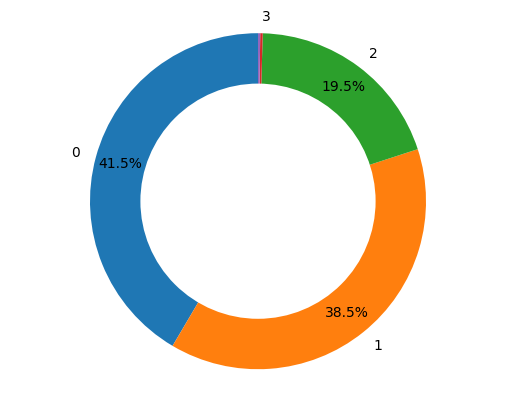

In [ ]:
# @title Result Possibility Check { form-width: "240px" }
Demand_location =  [53, 8] # @param {type:"raw"}
[Bar, Note] = Demand_location

Result_type = ["(0) Empty", "(1) Small Red", "(2) Small Blue", "(3) Big Red", "(4) Big Blue"]

def alignment(display_number):
  if(display_number<10) : return " " + str(display_number)
  return str(display_number)

predictResult_posibility = softmax(predictResult) if Possibilty_Computation == 'Raw -> Sum/Avg -> Softmax' else predictResult

location_existence = False
for location, possibility_distribution in zip(LocationToNotes, predictResult_posibility):
    if(location==Demand_location):
        possibilty = possibility_distribution.tolist()
        most_likely = possibilty.index(max(possibilty))
        choosen = [""]*5
        choosen[most_likely] = "(√)"

        print(f"Location: Bar {Bar} / Note {Note}")

        print("\nPossobility Distribution:\n")
        print(f" (0) Empty\t: {alignment(round(possibilty[0]*100, 2))}\t% {choosen[0]}")
        print(f" (1) Small Red\t: {alignment(round(possibilty[1]*100, 2))}\t% {choosen[1]}")
        print(f" (2) Small Blue\t: {alignment(round(possibilty[2]*100, 2))}\t% {choosen[2]}")
        print(f" (3) Big Red\t: {alignment(round(possibilty[3]*100, 2))}\t% {choosen[3]}")
        print(f" (4) Big Blue\t: {alignment(round(possibilty[4]*100, 2))}\t% {choosen[4]}")
        print("\nModel Prediction: " + Result_type[most_likely])

        # Generate pie chart
        labels = ['0', '1', '2', '3', '']
        sizes = possibilty

        # autopct='%1.1f%%' if size > 0.1 else '' 讓比例太小的類別不要顯示百分比
        fig, ax = plt.subplots()
        wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',
                                          startangle=90, pctdistance=0.85)

        # draw circle in the middle to make it a donut chart
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig.gca().add_artist(centre_circle)

        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.axis('equal')

        plt.show()
        location_existence = True
        break

if not location_existence: print("Location Not Found.")

In [ ]:
def closure():
  i = 0
  def add():
    i = i + 1
    return i
  return add

In [ ]:
closure1 = closure()


In [ ]:
closure1()

1

In [ ]:
for _ in range(5):
  print(closure1())

1
1
1
1
1


##Multiple To Single

In [42]:
# @title Model/Parameter Defining { form-width: "240px" }

# @title Model Main (single) { form-width: "240px" }

import torch
import torch.nn as nn
import torch.nn.functional as F

BATCH_FIRST = True # @param {type:"boolean"}
DUAL_CHANNEL = False # @param {type:"boolean"}
CHANNRL = 2 if DUAL_CHANNEL else 1

C = CHANNRL
ASIDE_NOTE = 7 # @param {type:"integer"}
SEQ = ASIDE_NOTE*2 + 1

Model_Design = 'New' # @param ["Old", "New"] {allow-input: false}

if Model_Design == 'Old':
  class Attention(nn.Module):
      def __init__(self, dim, n_heads, dropout):
          super().__init__()
          self.n_heads = n_heads
          self.att = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout, batch_first=BATCH_FIRST)
          self.q = torch.nn.Linear(dim, dim)
          self.k = torch.nn.Linear(dim, dim)
          self.v = torch.nn.Linear(dim, dim)

      def forward(self, input):
          output = []
          for x in input:
              q = self.q(x)
              k = self.k(x)
              v = self.v(x)
              attn_output, attn_output_weights = self.att(q, k, v)
              output.append(attn_output)
          output = torch.stack(output)
          return output

if Model_Design == 'New':
  class Attention(nn.Module):
      def __init__(self, dim, n_heads, dropout):
          super().__init__()
          self.n_heads = n_heads
          self.att = torch.nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout, batch_first=True)
          self.q = torch.nn.Linear(dim, dim)
          self.k = torch.nn.Linear(dim, dim)
          self.v = torch.nn.Linear(dim, dim)

      def forward(self, x):
          q = self.q(x)
          k = self.k(x)
          v = self.v(x)
          attn_output, attn_output_weights = self.att(q, k, v)
          return attn_output

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.feedforward = nn.Sequential \
        (
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.feedforward(x)

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class TaikoNoteClassfication(nn.Module):
    def __init__(self, out_dim, C=C, num_patches=SEQ, emb_dim=128, n_layers=6, dropout=0.1, heads=4):
        super(TaikoNoteClassfication, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=C, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        self.dropout = nn.Dropout(0.1)

        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))

        self.fc = nn.Linear(12288, emb_dim)

        # Attributes
        self.channels = C
        self.n_layers = n_layers

        # Learnable params
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential\
            (
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout)))
            )
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))

        #position_encoding
        PSE_UNIT = torch.ones(num_patches, emb_dim)
        for pos in range(num_patches):
          for i in range(emb_dim):
            x = i//2
            PSE_UNIT[pos][i] = torch.sin(torch.tensor(pos/1000**(x/emb_dim))) if (i % 2 == 0) else torch.cos(torch.tensor(pos/1000**(x/emb_dim)))
        self.basic_pos_emb_unit = PSE_UNIT.to(device)

        #self.fc_head = nn.Linear(emb_dim, out_dim*SEQ)
        self.final_fc = nn.Linear(out_dim*SEQ, out_dim)

        #self.final_zero_weight = nn.Parameter(torch.tensor([0,100,100,100,100]).float())


    def forward(self, x):

        batch_size, sequence_length, channels, height, width = x.size()
        x = x.view(batch_size * sequence_length, channels, height, width)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(batch_size, sequence_length, -1)  # Reshape to (batch_size, sequence_length, feature_dim)
        x = self.fc(x)
        # b, n, _ = x.shape

        # Add position encoding to inputs
        position_encoding = self.basic_pos_emb_unit.repeat(batch_size, 1, 1)
        x = x + position_encoding

        # Add cls token to inputs
        cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)
        final = self.head(x[:, 0, :])
        # final = torch.mul(final, self.final_zero_weight)
        return final

device = "cuda" if torch.cuda.is_available() else "cpu"
device

model = TaikoNoteClassfication(5).to(device)

# @title Parameters
MODEL_PATH = "/content/drive/MyDrive/20240730/aside_7_new/8_6248_7537.pth" # @param {type:"string"}
MAGNIFY = 1
FREQ_BINS = 64
SEGMENT = 100

#載入儲存好的模型
TaikoModel = TaikoNoteClassfication(5).to(device)
TaikoModel.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))
TaikoModel.state_dict()
TaikoModel.eval()

print("Model Has Loaded Sucessfully")


Model Has Loaded Sucessfully


In [43]:
# @title Fumen Predicting { form-width: "450px" }

def AdjustPeriod(period):
    while(period>=4): period = period/2
    while(period<=1/4): period = period*2
    return period

SOUNDWAVE, SR = torchaudio.load(Audio_path)
SOUNDWAVE = SOUNDWAVE * MAGNIFY
SOUNDWAVE = SOUNDWAVE.to(device)
FRAMES_LENGTH = len(SOUNDWAVE[0])

channel_num = (SOUNDWAVE.shape)[0]
assert channel_num==1 or channel_num==2, "Number of channel is not valid, expect 1 or 2."
if(channel_num==1 and DUAL_CHANNEL):      SOUNDWAVE = SOUNDWAVE.repeat(2, 1)                               #將單聲道轉為雙聲道
if(channel_num==2 and not DUAL_CHANNEL):  SOUNDWAVE = torch.unsqueeze((SOUNDWAVE[0]+SOUNDWAVE[1])/2, 0)    #將雙聲道轉為單聲道

ZERO_CHANNEL_TENSOR = torch.full((CHANNRL, 1), 0).to(device)

predictResult = []
predictBar = []
for NOTE_INDEX in tqdm(range(len(LocationToNotes))):
    def SoundPartByFrame(NOTE_OFFSRT):
        loop_index = NOTE_INDEX + NOTE_OFFSRT
        if(loop_index<0 or loop_index>=len(LocationToNotes)):
          return torch.zeros(CHANNRL, FREQ_BINS, SEGMENT+1).to(device)

        location = LocationToNotes[loop_index]
        [BAR, NOTE] = location
        BPM = BpmConfiguration[BAR][NOTE]
        PERIOD = AdjustPeriod(60 / BPM * 2)
        SHAPE = int(PERIOD*SEGMENT+1)

        EXACT_TIME = AbsoluteTime[loop_index]-PERIOD/2
        STARTING_FRAME = int(EXACT_TIME*SR)
        DURATION_FRAME = int(PERIOD*SR)
        #起始點是否在音樂開始前 / 起始點是否在音樂開始後 / 終止點是否在音樂開始前 / 終止點是否在音樂結束後
        IS_START_OUT_OF_MIN_INDEX = False if (STARTING_FRAME>=0) else True
        IS_START_OUT_OF_MAX_INDEX = False if (STARTING_FRAME<FRAMES_LENGTH) else True
        IS_FINAL_OUT_OF_NIN_INDEX = False if (STARTING_FRAME+DURATION_FRAME>=0) else True
        IS_FINAL_OUT_OF_NAX_INDEX = False if (STARTING_FRAME+DURATION_FRAME<FRAMES_LENGTH) else True

        assert not(IS_START_OUT_OF_MIN_INDEX and IS_START_OUT_OF_MAX_INDEX), f"The Start Window being Out Of Start/End point At The Same Time Doesn't Make Sense."
        assert not(IS_FINAL_OUT_OF_NIN_INDEX and IS_FINAL_OUT_OF_NAX_INDEX), f"The Final Window being Out Of Start/End point At The Same Time Doesn't Make Sense."

        match IS_START_OUT_OF_MIN_INDEX, IS_START_OUT_OF_MAX_INDEX, IS_FINAL_OUT_OF_NIN_INDEX, IS_FINAL_OUT_OF_NAX_INDEX:
            case False  , False , _     , False : #正常情況
                SLICE = SOUNDWAVE[:, STARTING_FRAME: STARTING_FRAME+DURATION_FRAME]
            case True   , False , False , False : #開頭超出音樂開頭處，結尾則在音樂內
                SLICE = SOUNDWAVE[:, 0: STARTING_FRAME+DURATION_FRAME]
                while(len(SLICE[0])<DURATION_FRAME): SLICE = torch.cat((ZERO_CHANNEL_TENSOR, SLICE), dim=1)
            case True   , False , True , False : #開頭和結尾都超出音樂開頭處
                SLICE = torch.zeros(CHANNRL, DURATION_FRAME).to(device)
            case False  , False , _    , True  : #結尾超出音樂結束處，開頭則在音樂內
                SLICE = SOUNDWAVE[:, STARTING_FRAME: FRAMES_LENGTH]
                while(len(SLICE[0])<DURATION_FRAME): SLICE = torch.cat((SLICE, ZERO_CHANNEL_TENSOR), dim=1)
            case False  , True  , _    , True  : #開頭跟結尾都已經在整首音樂結束後了
                SLICE = torch.zeros(CHANNRL, DURATION_FRAME).to(device)
            case True   , _     , _    , True  : #不合理的情況，起始點在音樂開始前，終止點在音樂結束後
                raise Exception(f"Chosen Segment Is Less Then {PERIOD}s.")

        to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate = DURATION_FRAME,  n_fft = 1024,       n_mels = FREQ_BINS,
            hop_length = int( DURATION_FRAME / SEGMENT ),      f_min = 0,         f_max = int(SR/2),  normalized = True).to(device)

        log_mel_spec = to_mel_spectrogram(SLICE)
        return log_mel_spec

    info_per_note = []
    for aside_from_center in range(-ASIDE_NOTE, ASIDE_NOTE+1):
        info_per_note.append(SoundPartByFrame(aside_from_center))
    info_per_note = torch.stack(info_per_note)

    with torch.inference_mode():
      Result = TaikoModel(torch.unsqueeze(info_per_note, 0).to(device))
      Result = torch.squeeze(Result)
    predictResult.append(Result)
    predictBar.append(Result.argmax().item())

for x, y in zip(LocationToNotes, predictBar): song_branched.EveryBar[x[0]] = song_branched.EveryBar[x[0]][:x[1]] + str(y) + song_branched.EveryBar[x[0]][x[1]+1:]

  0%|          | 0/7712 [00:00<?, ?it/s]

In [41]:
# @title Result { form-width: "240px" }

BarNumberDisplayed = True # @param {type:"boolean"}
Result_Display = "Save As File" # @param ["Print Out", "Save As File"]

#印出結果
TempContent = song_branched.OffsetThingsValue("BPM:",[song_branched.ChosenReady,song_branched.ChosenBegin]) #預設使用譜面開始前設定的BPM
if(TempContent==""): TempContent = song_branched.OffsetThingsValue("BPM:",[0, song_branched.Song_Begin[0]]) #沒有該譜面自設定的BPM，則沿用譜面檔案一開始能找到的數值

TITLE = song_branched.TITLE
SUBTITLE = song_branched.OffsetThingsValue("SUBTITLE:",[0,len(song_branched.EveryRow)])
INIT_BPM = TempContent
WAVE = song_branched.OffsetThingsValue("WAVE:",[0,len(song_branched.EveryRow)])
OFFSET = OFFSET
LEVEL = 9 # @param {type:"integer"}
COURSE = 3 # @param {type:"integer"}

_bpm = float(TempContent)
_scr = 1
_measure = [4, 4]
_barline = True
_gogo = False
_note = None

set_bpm = song_branched.BPMValueSet
set_scr = song_branched.ScrollSet
set_measure = song_branched.BeatsToMeasureSet
set_barline = song_branched.BarlineSet
set_gogo = song_branched.GOGOSet
set_delay = song_branched.DelaySet

Remastered_fumen = ""

#Basic Info
Remastered_fumen += f"TITLE:{TITLE}\n"
Remastered_fumen += f"SUBTITLE:{SUBTITLE}\n"
Remastered_fumen += f"BPM:{INIT_BPM}\n"
Remastered_fumen += f"WAVE:{WAVE}\n"
Remastered_fumen += f"OFFSET:{OFFSET}\n"
Remastered_fumen += f"LEVEL:{LEVEL}\n"
Remastered_fumen += f"COURSE:{COURSE}\n"

Remastered_fumen += "#START\n"

#Actual Fumen Context
for bar, bar_bpm, bar_scr, bar_measure, bar_barline, bar_gogo, bar_delay in zip(song_branched.EveryBar, set_bpm, set_scr, set_measure, set_barline, set_gogo, set_delay):
    for note, bpm, scr, measure, barline, gogo, delay in zip(bar, bar_bpm, bar_scr, bar_measure, bar_barline, bar_gogo, bar_delay):
        IsCommandChange = True if (_bpm, _scr, _measure, _barline, _gogo) != (bpm, scr, measure, barline, gogo) else False
        #如果現在有指令的話，會在開頭自動加上一次換行。而如果上一個位置就是小節結束點(換行)，那就省掉上一次加的換行
        if( IsCommandChange and ( _note == "," or _note is None ) ):  Remastered_fumen = Remastered_fumen[:-1]
        if(_bpm!=bpm):
            _bpm = bpm
            Remastered_fumen = Remastered_fumen + f"\n#BPMCHANGE {bpm}"
        if(_scr!=scr):
            _scr = scr
            Scroll_text = str(scr.real) if (scr.imag==0) else f"{scr.real}+{scr.imag}i"
            Remastered_fumen = Remastered_fumen + f"\n#SCROLL {Scroll_text}"
        if(_measure!=measure):
            _measure = measure
            Remastered_fumen = Remastered_fumen + f"\n#MEASURE {measure[0]}/{measure[1]}"
        if(_barline!=barline):
            _barline = barline
            Barline_text = "#BARLINEON" if barline else "#BARLINEOFF"
            Remastered_fumen = Remastered_fumen + f"\n{Barline_text}"
        if(_gogo!=gogo):
            _gogo = gogo
            GOGO_text = "#GOGOSTART" if gogo else "#GOGOEND"
            Remastered_fumen = Remastered_fumen + f"\n{GOGO_text}"
        if(delay!=0):
            Remastered_fumen = Remastered_fumen + f"\n#DELAY {delay}\n"

        Extra_Newline = "\n" if IsCommandChange else ""
        Remastered_fumen = Remastered_fumen + Extra_Newline + note
        _note = note

    Remastered_fumen = Remastered_fumen + "\n"

Remastered_fumen = Remastered_fumen + "#END"

#Add Bar Number
if BarNumberDisplayed:
  Remastered_fumen_with_bar = ""
  bar = 0
  for char in Remastered_fumen:
    Remastered_fumen_with_bar = Remastered_fumen_with_bar + char
    if char==",":
      bar = bar + 1
      Remastered_fumen_with_bar = Remastered_fumen_with_bar + f"//{bar}"
  Remastered_fumen = Remastered_fumen_with_bar

#Model Used
Remastered_fumen = Remastered_fumen + f"\n\n//Sequence Length: {SEQ}\n//Model Used:\n//{MODEL_PATH}"

#Display/Save File
match Result_Display:
  case "Print Out":
    print(Remastered_fumen)
  case "Save As File":
    FILE_NAME = song_branched.TITLE + '_' + song_branched.COURSE + '.tja'
    with open(FILE_NAME, 'w', encoding=Codec) as writer:
      writer.write(Remastered_fumen)
    print(f"Succesfully Ouput As A File Called \"{FILE_NAME}\"")
  case _:
    raise Exception("Invalid Choice")



Succesfully Ouput As A File Called "Touhou_Suite_Oni.tja"


Location: Bar 117 / Note 0

Possobility Distribution:

 (0) Empty	: 28.54	% 
 (1) Small Red	: 57.85	% (√)
 (2) Small Blue	: 13.24	% 
 (3) Big Red	:  0.24	% 
 (4) Big Blue	:  0.13	% 

Model Prediction: (1) Small Red


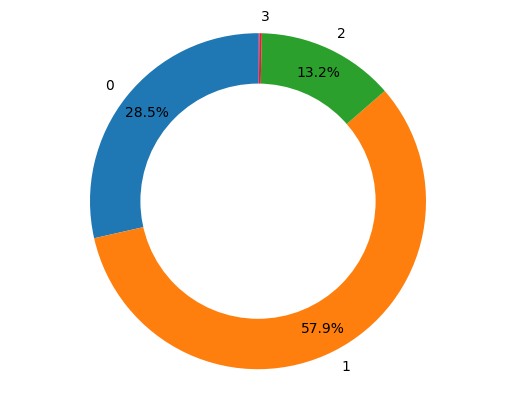

In [46]:
# @title Result Possibility Check { form-width: "240px" }
import matplotlib.pyplot as plt
Demand_location =  [117, 0] # @param {type:"raw"}
[Bar, Note] = Demand_location

Result_type = ["(0) Empty", "(1) Small Red", "(2) Small Blue", "(3) Big Red", "(4) Big Blue"]

softmax = nn.Softmax(dim=1)

def alignment(display_number):
  if(display_number<10) : return " " + str(display_number)
  return str(display_number)

location_existence = False
for location, possibility_distribution in zip(LocationToNotes, softmax(torch.stack(predictResult))):
    if(location==Demand_location):
        possibilty = possibility_distribution.tolist()
        most_likely = possibilty.index(max(possibilty))
        choosen = [""]*5
        choosen[most_likely] = "(√)"

        print(f"Location: Bar {Bar} / Note {Note}")

        print("\nPossobility Distribution:\n")
        print(f" (0) Empty\t: {alignment(round(possibilty[0]*100, 2))}\t% {choosen[0]}")
        print(f" (1) Small Red\t: {alignment(round(possibilty[1]*100, 2))}\t% {choosen[1]}")
        print(f" (2) Small Blue\t: {alignment(round(possibilty[2]*100, 2))}\t% {choosen[2]}")
        print(f" (3) Big Red\t: {alignment(round(possibilty[3]*100, 2))}\t% {choosen[3]}")
        print(f" (4) Big Blue\t: {alignment(round(possibilty[4]*100, 2))}\t% {choosen[4]}")
        print("\nModel Prediction: " + Result_type[most_likely])

        # Generate pie chart
        labels = ['0', '1', '2', '3', '']
        sizes = possibilty

        # autopct='%1.1f%%' if size > 0.1 else '' 讓比例太小的類別不要顯示百分比
        fig, ax = plt.subplots()
        wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',
                                          startangle=90, pctdistance=0.85)

        # draw circle in the middle to make it a donut chart
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig.gca().add_artist(centre_circle)

        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.axis('equal')

        plt.show()
        location_existence = True
        break

if not location_existence: print("Location Not Found.")

##Unused Parts

In [ ]:
torch.tensor(range(NOTE_INDEX-15, NOTE_INDEX+1))

tensor([3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192,
        3193, 3194, 3195, 3196])

In [ ]:
Result = TaikoModel(torch.unsqueeze(predictBar, 0).to(device))

In [ ]:
Result.shape

torch.Size([1, 16, 5])

In [ ]:
song_branched.EveryBar[0]

"1001101000001010ensor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')tttttttttttttttensor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')tttttttttttttttensor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(1, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device='cuda:0')nsor(0, device

In [ ]:
summary(model=TaikoModel, input_size=(128,2,64,101), col_names=['input_size', 'output_size', 'num_params', 'trainable'])

In [ ]:
# for x, y in zip(LocationToNotes, predictBar):
#   print(f"\r{x}     ",end='')
#   song_branched.EveryBar[x[0]] = song_branched.EveryBar[x[0]][:x[1]] + str(y) + song_branched.EveryBar[x[0]][x[1]+1:]


In [ ]:
"Aaaa".lower()

In [ ]:
import time

In [ ]:
def fib(x:int) -> int:
    assert x>=0, "Input Cannot Be Negative."
    if x==0 : return 0
    init = [0,0,1]
    for _ in range(x - 1): init = [init[1], init[2], init[1] + init[2]]
    return init[2]

#1, 1, 2, 3, 5, 8, 13, 21


In [ ]:
def ReducedBar(Bar):
    All_Zero_Except_First = True
    for Note in Bar[1:]:
        if(Note!='0' and Note!=','):
            All_Zero_Except_First = False
            break
    if All_Zero_Except_First:
        if Bar[0]!='0' : return Bar[0] + ','
        else: return ','

    Prime = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
    for Number in Prime:
        TempBar = ''
        Reducable = True
        for i in range(len(Bar)):
            if( i%Number!=0 and Bar[i]!='0' ):
                Reducable = False
                break
            if i%Number==0 : TempBar = TempBar + Bar[i]
        if Reducable: return ReducedBar(TempBar)
    return Bar


In [ ]:
def ReducedRow(Row):
    Row_Decomposition = Row.split('//')
    Actual = Row_Decomposition[0]
    Extra = "//" + Row_Decomposition[1] if len(Row_Decomposition)==2 else ""

    All_Zero_Except_First = True
    for Note in Actual[1:]:
        if(Note!='0' and Note!=','):
            All_Zero_Except_First = False
            break
    if All_Zero_Except_First:
        if Actual[0]!='0' : return Actual[0]
        else: return ''

    Prime = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
    for Number in Prime:
        TempBar = ''
        Reducable = True
        for i in range(len(Actual)):
            if( i%Number!=0 and Actual[i]!='0' ):
                Reducable = False
                break
            if i%Number==0 : TempBar = TempBar + Actual[i]
        if Reducable: return ReducedBar(Actual) + Extra
    return Actual

In [ ]:
def IsEveryInArrayEqual(Array):
    for i in range(len(Array)-1):
        if(Array[i]!=Array[i+1]): return False
    return True

In [ ]:
list(range(0,5,2))

In [ ]:
def ReducedInfoSet(Set):
    Prime = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
    Temp_Reduced_Set = Set[:]
    print(Temp_Reduced_Set)
    #Reduced_mapping = {}
    for Number in Prime:
        Temp_Reduced_Set = []
        Is_EverySegEqual = True
        for i in range(0, len(Set), Number):
            ComardList = Set[i:i+Number]
            print(i,i+Number)
            if not IsEveryInArrayEqual(ComardList): Is_EverySegEqual = False
            Temp_Reduced_Set.append(Set[i])
            time.sleep(0.15)
            print(ComardList, IsEveryInArrayEqual(ComardList))
        #Reduced_mapping[Number] = Temp_Reduced_Set
        print(f"{Number}")
        #time.sleep(1.5)
        print("\n")

        print(Is_EverySegEqual)
        if Is_EverySegEqual:
            return  ReducedInfoSet(Temp_Reduced_Set)
    return Set

In [ ]:
IsEveryInArrayEqual([2,2,[1,2]])

In [ ]:
[[1,4],[2,3],[2,5],[True,56],{2,5},[5,2]][1:5]

In [ ]:
CustomLayer = [(1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (1+0j), (10+0j)]
CustomLayer[:-1]

In [ ]:
song_branched.ScrollSet[21]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

C = CHANNRL
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

class TaikoNoteClassfication(nn.Module):
    def __init__(self, num_classes, embed_size=256, heads=8):
        super(TaikoNoteClassfication, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=C, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))

        self.fc1 = nn.Linear(128 * 8 * (101//8), embed_size)
        self.attention = SelfAttention(embed_size, heads)
        self.fc2 = nn.Linear(embed_size, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, sequence_length, channels, height, width = x.size()
        x = x.view(batch_size * sequence_length, channels, height, width)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(batch_size, sequence_length, -1)  # Reshape to (batch_size, sequence_length, feature_dim)

        x = F.relu(self.fc1(x))
        x = self.attention(x, x, x, mask=None)  # Self-Attention mechanism

        x = F.relu(self.fc2(x))  # Apply to all time steps
        x = self.fc3(x)  # Final classification layer

        return x

In [ ]:
ReducedInfoSet(song_branched.ScrollSet[21])

In [ ]:
ReducedInfoSet(song_branched.ScrollSet)==song_branched.ScrollSet

In [ ]:
song_branched.ScrollSet[21]

In [ ]:
song_branched = TaikoFumenBranched("D:/taikojiro/english/bitch lasagna/bitch lasagna.tja", Codec, 0, None)

In [ ]:
song_branched.BranchStateSet

In [ ]:
"A".isnumeric()

In [ ]:
"10001010,"[]

In [ ]:
"10000000000000000000000000000000000000000000000000000000000000000000000000000000000000,"[1:]

In [ ]:
len("10000000000000000000000000000000000000000000000000000000000000000000000000000000000000,")

In [ ]:
ReducedBar("100010001000")

In [ ]:
Row = "1000000000100000000,"
(len(Row)-1)/(len(ReducedBar(Row))-1)

In [ ]:
for _ in song_branched.EveryBar:  print(_)

In [ ]:
song_branched.EveryBar[0]

In [ ]:
CustomLayer = f"a{bpm}1"
CustomLayer

In [ ]:
note, bpm, scr, measure, barline, gogo, delay

In [ ]:
len(set_bpm[0])==len(set_scr[0])==len(set_measure[0])==len(set_barline[0])==len(set_gogo[0])==len(set_delay[0])==len(song_branched.EveryBar[0])

In [ ]:
summary(model=TaikoModel)

In [ ]:
embed_dim = 4
num_heads = 1

x = [
  [1, 0, 1, 0], # Seq 1
  [0, 2, 0, 2], # Seq 2
  [1, 1, 1, 1]  # Seq 3
 ]
x = torch.tensor(x, dtype=torch.float32)

w_key = [
  [0, 0, 1, 1],
  [1, 1, 0, 1],
  [0, 1, 0, 1],
  [1, 1, 0, 1]
]
w_query = [
  [1, 0, 1, 1],
  [1, 0, 0, 1],
  [0, 0, 1, 1],
  [0, 1, 1, 1]
]
w_value = [
  [0, 2, 0, 1],
  [0, 3, 0, 1],
  [1, 0, 3, 1],
  [1, 1, 0, 1]
]
w_key = torch.tensor(w_key, dtype=torch.float32)
w_query = torch.tensor(w_query, dtype=torch.float32)
w_value = torch.tensor(w_value, dtype=torch.float32)

keys = (x @ w_key).unsqueeze(0)     # to batch mode
querys = (x @ w_query).unsqueeze(0)
values = (x @ w_value).unsqueeze(0)

print(keys.shape, querys.shape, values.shape)

multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
attn_output, attn_output_weights = multihead_attn(querys, keys, values)
attn_output, attn_output_weights

torch.Size([1, 3, 4]) torch.Size([1, 3, 4]) torch.Size([1, 3, 4])


(tensor([[[ 1.6674, -1.6928,  1.2547, -0.1899],
          [ 1.7923, -1.7901,  1.3771, -0.2072],
          [ 1.7925, -1.7902,  1.3773, -0.2072]]], grad_fn=<TransposeBackward0>),
 tensor([[[1.6850e-02, 8.6976e-01, 1.1339e-01],
          [2.2599e-04, 9.8244e-01, 1.7335e-02],
          [2.8874e-04, 9.8269e-01, 1.7018e-02]]], grad_fn=<MeanBackward1>))